In [1]:
%pylab inline

import numpy as np
import tensorflow as tf

from scipy import integrate
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

import keras
from keras import optimizers
from keras.models import Model,Sequential,load_model
from keras.layers import Input,Dense,Reshape,Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.utils import plot_model

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

def rad_bas(x):
    return K.exp(-x**2)
get_custom_objects().update({'rad_bas': Activation(rad_bas)})

def tan_sig(x):
    return 2/(1+K.exp(-2*x))-1
get_custom_objects().update({'tan_sig': Activation(tan_sig)})

In [3]:
def progress_bar(percent):
    length = 40
    pos = round(length*percent)
    clear_output(wait=True)
    print('['+'█'*pos+' '*(length-pos)+']  '+str(int(100*percent))+'%')

## Load RD trajectories
Trajectories have been generated in MATLAB for randomly generated initial conditions.

In [2]:
N = 128
T = 201
num_iter = 20
num_tests = 1
RD_all_data = np.zeros((num_iter-num_tests,T,N,2*N))
RD_input_data = np.zeros(((T-1)*(num_iter-num_tests),N,2*N))
RD_target_data = np.zeros(((T-1)*(num_iter-num_tests),N,2*N))

for i in range(num_iter-num_tests):
    d = loadmat('PDECODES/RD_data/N'+str(N)+'/iter'+str(i+1)+'.mat')
    u = d['u']
    v = d['v'] 
    RD_all_data[i,:,:,:N] = u[:,:,:].T
    RD_all_data[i,:,:,N:] = v[:,:,:].T
    RD_input_data[i*(T-1):(i+1)*(T-1),:,:] = RD_all_data[i,:-1,:,:]
    RD_target_data[i*(T-1):(i+1)*(T-1),:,:] = RD_all_data[i,1:,:,:]
#    RD_input_data[i*(T-1):(i+1)*(T-1),:,:N] = u[:,:,:-1].T
#    RD_input_data[i*(T-1):(i+1)*(T-1),:,N:] = v[:,:,:-1].T
#    RD_target_data[i*(T-1):(i+1)*(T-1),:,:N] = u[:,:,1:].T
#    RD_target_data[i*(T-1):(i+1)*(T-1),:,N:] = v[:,:,1:].T

In [3]:
RD_test_data = np.zeros((T*num_tests,N,2*N))
for i in range(num_tests):
    d = loadmat('PDECODES/RD_data/N'+str(N)+'/iter'+str(num_iter-i)+'.mat')
    u = d['u']
    v = d['v']
    RD_test_data[i*T:(i+1)*T,:,:N] = u.T
    RD_test_data[i*T:(i+1)*T,:,N:] = v.T

In [6]:
RD_input_data.shape

(3800, 32, 64)

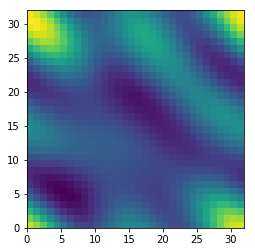

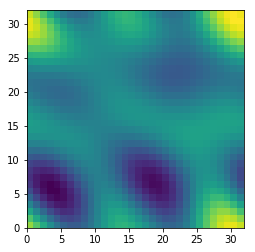

In [7]:
plt.pcolormesh(RD_input_data[200,:,:N])
plt.axis('image')
plt.show()

plt.pcolormesh(RD_input_data[200,:,N:])
plt.axis('image')
plt.show()

plt.figure(figsize=(6,3.3))
m = plt.pcolormesh(np.reshape(uu[:,i],(N,2*N)))
m.set_rasterized(True)
plt.axis('image')
plt.savefig('img/svd_mode_'+str(i+1)+'.pdf')
plt.gcf().get_size_inches()

array([6. , 3.3])

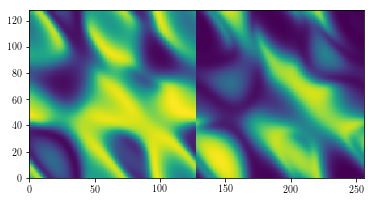

In [7]:
i=14
mpl.rcParams['text.usetex'] = True
plt.figure(figsize=(6,3.3))
m = plt.pcolormesh(RD_test_data[15,:,:])
m.set_rasterized(True)
plt.axis('image')
plt.savefig('img/prediction_t'+str(i+1)+'.pdf')
plt.gcf().get_size_inches()

## Train Neural Network on Full Data

In [64]:
model = Sequential()
model.add(Dense(N*2*N, activation='tan_sig', use_bias=True, input_shape=(N*2*N,)))
model.add(Dense(N*2*N, activation='sigmoid', use_bias=True))
#model.add(Dense(N*2*N, activation='linear', use_bias=True))
model.add(Dense(N*2*N))

In [65]:
sgd1 = keras.optimizers.SGD(lr=0.001, decay=1e-15, momentum=1, nesterov=True)
adam1 = keras.optimizers.Adam(lr=.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=True, clipvalue=0.5)
nadam1 = keras.optimizers.Nadam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
rmsprop1 = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

In [66]:
model.compile(loss='mean_squared_error', optimizer=adam1, metrics=['accuracy'])
#plot_model(model, to_file='model.pdf', show_shapes=True)

In [ ]:
mpl.rcParams['text.usetex'] = False
model.fit(
    np.reshape(RD_input_data,(-1,N*2*N)), 
    np.reshape(RD_target_data,(-1,N*2*N)), 
    epochs=1000, batch_size=800, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [68]:
RD_NN_prediction = np.zeros(np.reshape(RD_test_data[0:T],(-1,N*2*N)).shape)
RD_NN_prediction[0] = np.reshape(RD_test_data[0],(-1,N*2*N))
for k in range(T-1):
    RD_NN_prediction[k+1] = model.predict(np.array([RD_NN_prediction[k]]))

In [69]:
np.reshape(RD_NN_prediction,(-1,N,2*N)).shape

(201, 32, 64)

(0.0, 64.0, 0.0, 32.0)

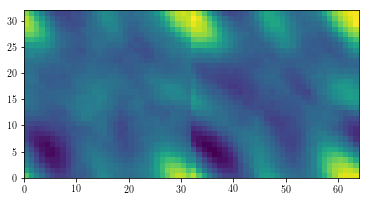

In [72]:
mpl.rcParams['text.usetex'] = True
i=15
m = plt.pcolormesh(np.reshape(RD_NN_prediction,(-1,N,2*N))[i])
m.set_rasterized(True)
plt.axis('image')
plt.savefig('img/predicted_RD_'+str(i)+'_trajectory.pdf')

In [ ]:
np.reshape(np.reshape(RD_input_data,(-1,N*2*N)),(-1,N,2*N))

RD_input_data

## Compute SVD
Reshape data and compute rank k approximation to find fixed subspace to which we project our spatial ponints at each time.

In [6]:
RD_all_data.shape

(19, 201, 128, 256)

In [7]:
RD_all_data_reshaped = np.reshape(RD_all_data[:,:,:,],(-1,2*N*N)).T

In [8]:
np.shape(RD_all_data_reshaped)

(32768, 3819)

In [9]:
[uu,ss,vvh] = np.linalg.svd(RD_all_data_reshaped,full_matrices=False)

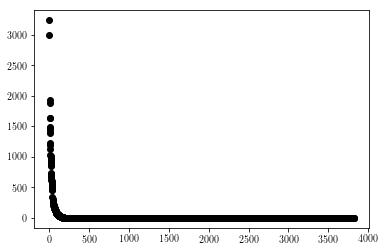

In [11]:
mpl.rcParams['text.usetex'] = True
plt.scatter(np.arange(len(ss)),ss,color='k')
plt.savefig('img/singular_values.pdf')

array([6. , 3.3])

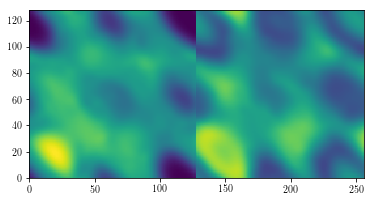

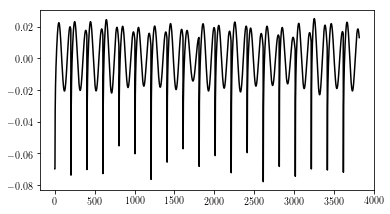

In [13]:
i=0
plt.figure(figsize=(6,3.3))
m = plt.pcolormesh(np.reshape(uu[:,i],(N,2*N)))
m.set_rasterized(True)
plt.axis('image')
plt.savefig('img/svd_mode_'+str(i+1)+'.pdf')
plt.gcf().get_size_inches()

plt.figure(figsize=(6,3.3))
plt.plot(np.arange(len(vvh[i])),vvh[i],color='k')
plt.savefig('img/svd_coeff_'+str(i+1)+'.pdf')
plt.gcf().get_size_inches()

Set rank and take reduced SVD

In [14]:
rank = 100
u = uu[:,:rank]
s = ss[:rank]
vh = vvh[:rank]

In [15]:
SVD_input_data = np.delete(vh,np.s_[200::201],axis=1).T
SVD_target_data = np.delete(vh,np.s_[1::201],axis=1).T
SVD_input_data.shape

(3800, 100)

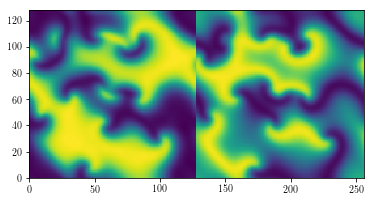

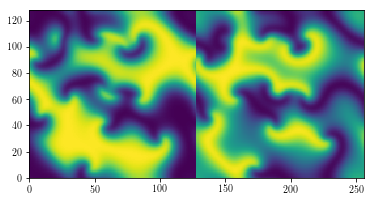

In [21]:
plt.figure(figsize=(6,3.3))
m = plt.pcolormesh(np.reshape(u@np.diag(s)@SVD_input_data[180],(N,2*N)))
m.set_rasterized(True)
plt.axis('image')
plt.savefig('img/uv_t180.pdf')

plt.figure(figsize=(6,3.3))
m = plt.pcolormesh(RD_all_data[0,180])
m.set_rasterized(True)
plt.axis('image')
plt.savefig('img/svd_t180.pdf')


## Train Net on SVD data

In [39]:
model = Sequential()
model.add(Dense(2*rank, activation='tan_sig', use_bias=True, input_shape=(rank,)))
model.add(Dense(2*rank, activation='sigmoid', use_bias=True))
model.add(Dense(2*rank, activation='linear', use_bias=True))
model.add(Dense(rank))

In [40]:
sgd1 = keras.optimizers.SGD(lr=0.001, decay=1e-15, momentum=1, nesterov=True)
adam1 = keras.optimizers.Adam(lr=.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=True, clipvalue=0.5)
nadam1 = keras.optimizers.Nadam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
rmsprop1 = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

In [41]:
model.compile(loss='mean_squared_error', optimizer=adam1, metrics=['accuracy'])

In [42]:
mpl.rcParams['text.usetex'] = False
model.fit(
    SVD_input_data, 
    SVD_target_data,
    epochs=1000, batch_size=80, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

Epoch 67/1000
1840/3800 [=============>................] - ETA: 0s - loss: 2.4249e-04 - acc: 0.0049   

KeyboardInterrupt: 

In [43]:
SVD_test_data = np.reshape(RD_test_data[0:T],(-1,N*2*N))@u

In [44]:
SVD_NN_prediction = np.zeros(SVD_test_data.shape)
SVD_NN_prediction[0] = SVD_test_data[0]
for k in range(T-1):
    SVD_NN_prediction[k+1] = model.predict(np.array([SVD_NN_prediction[k]]))

<IPython.core.display.Javascript object>


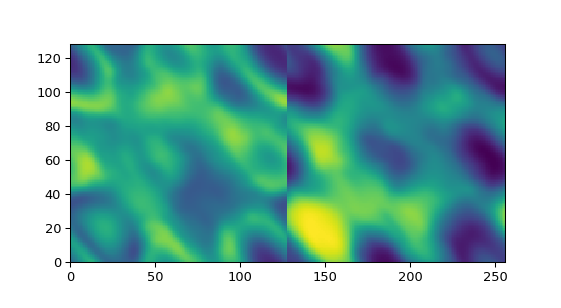

In [47]:
plt.figure(figsize=(6,3.3))
m = plt.pcolormesh(np.reshape(u@np.diag(s)@SVD_NN_prediction[15],(N,2*N)))
m.set_rasterized(True)
plt.axis('image')
plt.savefig('img/svd_prediction_t15.pdf')

In [153]:
SVD_input_data[0].shape

(100,)

ValueError: x and y must be the same size

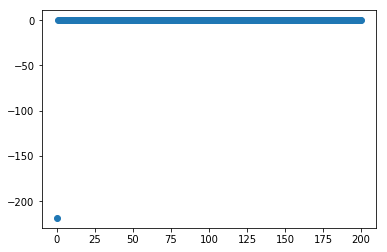

In [36]:
plt.figure()
plt.scatter(np.arange(T),SVD_NN_prediction[:,0])
plt.scatter(np.arange(T-1),SVD_input_data[:,0])
plt.show()

<IPython.core.display.Javascript object>


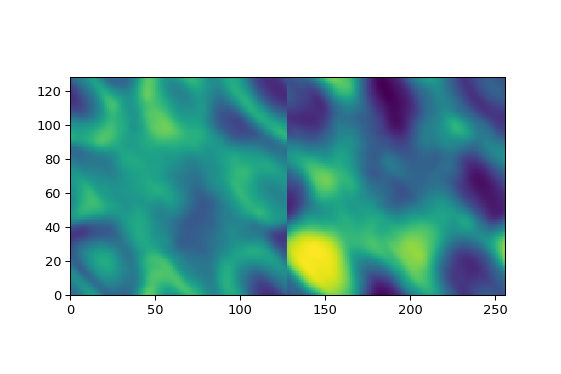

In [38]:
%matplotlib notebook
import matplotlib.animation

t = np.arange(T)

fig, ax = plt.subplots()

def animate(i):
    plt.pcolormesh(np.reshape(u@np.diag(s)@SVD_NN_prediction[i],(N,2*N)))
#    plt.pcolormesh(RD_all_data[0,i])
    plt.axis('image')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

plt.show()
